In [101]:
from surprise import Dataset, SVD, KNNBasic
from surprise.model_selection import KFold, cross_validate
from surprise.reader import Reader
from time import time
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import operator

In [65]:
def means(out):
    '''
    `out` is an output from a Surprise algorithm. Returns the mean
    MAE and RMSE
    '''
    return {'mae': np.mean([out['test_mae']]), 'rmse': np.mean(out['test_rmse'])}

In [130]:
'''
Task 3 part a - load the data
'''

data = '/home/jimge/public/CAP5610/hw5/ratings_small.csv'
df = pd.read_csv(data)
#
# load_from_df wants three columns: user id, item is, rating
#
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], Reader())

In [149]:
'''
Task 3 part c - compute RMSE/MAE for PMF, user-based CF, item-base CF
'''
kf = KFold(random_state=0)
#
# NB per the Surprise docs, SVD with biased == False is PMF
#
t = time()
pmf = cross_validate(SVD(biased = False), data, ['rmse', 'mae'], kf)
print('PMF took ',time() - t)
t = time()
ucf = cross_validate(KNNBasic(sim_options={'user_based': True}, verbose=False), data, ['rmse', 'mae'], kf)
print('UCF took', time() - t)
t = time()
icf = cross_validate(KNNBasic(sim_options={'user_based': False}, verbose=False), data, ['rmse', 'mae'], kf)
print('ICF took', time() - t)

PMF took  22.552604913711548
UCF took 9.465842485427856
ICF took 43.61047101020813


In [155]:
'''
Task 3 part c - format trials for LaTex table
'''
def fstr(f):
    return '%6.3f' % f
for (name, results) in zip(['PMF', 'UCF', 'ICF'], [pmf, ucf, icf]):
    print(name, '&', ' & '.join(map(fstr, results['test_rmse'])), '&', ' & '.join(map(fstr, results['test_mae'])))
    
    

PMF &  1.012 &  1.014 &  1.014 &  1.005 &  1.007 &  0.782 &  0.784 &  0.781 &  0.777 &  0.777
UCF &  0.968 &  0.973 &  0.973 &  0.971 &  0.958 &  0.743 &  0.746 &  0.748 &  0.747 &  0.737
ICF &  0.932 &  0.937 &  0.937 &  0.939 &  0.928 &  0.718 &  0.722 &  0.723 &  0.725 &  0.715


In [133]:
'''
Task 3 part d - compute average RMSE/MAE for PMF, user-based CF, item-base CF
'''
header = ('Algorithm', 'RMSE', 'MAE')
pmf_err = ('PMF', np.mean(pmf['test_rmse']), np.mean(pmf['test_mae']))
ucf_err = ('UCF', np.mean(ucf['test_rmse']), np.mean(ucf['test_mae']))
icf_err = ('ICF', np.mean(icf['test_rmse']), np.mean(icf['test_mae']))

hdr  = '%-12s %6s %6s' % header
rows = map(lambda row: '%-12s %6.3f %6.3f' % row, [pmf_err, ucf_err, icf_err] )

print('\n'.join([hdr]+list(rows)))

Algorithm      RMSE    MAE
PMF           1.007  0.778
UCF           0.968  0.744
ICF           0.935  0.721


In [135]:
'''
Task 3 part e - compute error for cosine, MSD, and Pearson similarities
on UCF and ICF
'''
metrics = ['cosine', 'msd', 'pearson']
out_sim = []
for m in metrics:
    t = time()
    o = cross_validate(KNNBasic(sim_options={'name': m, 'user_based': True}, verbose=False), data, ['rmse', 'mae'], kf)
    out_sim.append((m, 'UCF', o))
    print('UCF-%s took' % m, time() - t)
    t = time()
    o = cross_validate(KNNBasic(sim_options={'name': m, 'user_based': False}, verbose=False), data, ['rmse', 'mae'], kf)
    out_sim.append((m, 'ICF', o))
    print('ICF-%s took' % m, time() - t)
    

UCF-cosine took 20.178842306137085
ICF-cosine took 81.96030378341675
UCF-msd took 12.963815689086914
ICF-msd took 47.62882614135742
UCF-pearson took 14.150273323059082
ICF-pearson took 101.6791045665741


Metric   Alg   RMSE    MAE
pearson  UCF  0.998  0.773
cosine   UCF  0.994  0.768
msd      UCF  0.968  0.744
cosine   ICF  0.994  0.774
pearson  ICF  0.989  0.768
msd      ICF  0.935  0.721


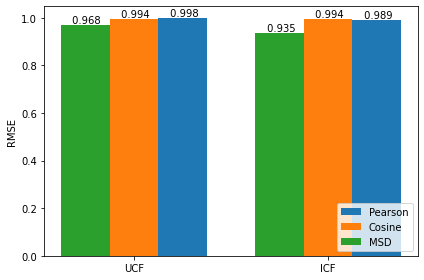

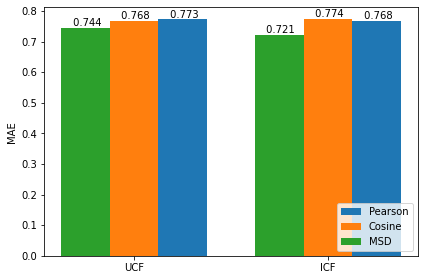

In [258]:
'''
Task 3 part e - evaluate cosine, MSD, and Pearson similarities
on UCF and ICF
'''
rows = list(map(lambda row: (row[0], row[1], means(row[2])), out_sim))

ucf = list(filter(lambda row: row[1] == 'UCF', rows))
icf = list(filter(lambda row: row[1] == 'ICF', rows))
          
ucf.sort(key = lambda x: x[2]['rmse'], reverse=True)
icf.sort(key = lambda x: x[2]['rmse'], reverse=True)

rows = ucf + icf

strrows = list(map(lambda x: '%-8s %3s %6.3f %6.3f' % (x[0], x[1], x[2]['rmse'], x[2]['mae']), rows))
hdr = ['%-8s %3s %6s %6s' % ('Metric', 'Alg', 'RMSE', 'MAE')]
print('\n'.join(hdr + strrows))

def stat(alg, sim, metric):
    return [x for x in rows if x[0] == sim and x[1] == alg][0][2][metric]

sims = [('pearson', 'Pearson'), ('cosine', 'Cosine'), ('msd', 'MSD')]
algs = ['UCF', 'ICF']
errs = ['rmse', 'mae']

for err in errs:
    # errdata[alg][sim]
    errdata = list(map(lambda s: list(map(lambda a: stat(a, s[0], err), algs)), sims))
    x = np.arange(len(algs))
    fig, ax = plt.subplots()
    rects = []
    width = 0.25
    for n, d in enumerate(errdata):
        rects.append(ax.bar(x - (width * (n-1)), d, width, label=sims[n][1]))
    ax.set_ylabel(err.upper())
    ax.set_xticks(x)
    ax.set_xticklabels(algs)
    ax.legend(loc='lower right')

    for (i, r) in enumerate(rects):
        for (j, p) in enumerate(r.patches):
            px = p.get_x()
            pw = p.get_width()
            h = errdata[i][j]
            ax.text(px + pw / 2, h, '%6.3f' % h, ha='center', va='bottom')
    fig.tight_layout()
    plt.savefig('/home/jimge/public/CAP5610/hw5/%s.png' % err)



In [283]:
'''
Task 3 part f - compute KNN for a bunch of K on UCF
'''
ucf_k_range = list(range(1, 80))
out_ucf_k = []
for k in ucf_k_range:
    t = time()
    ucf = cross_validate(KNNBasic(k=k, sim_options={'user_based': True}, verbose=False), data, ['rmse'], kf)
    print(time()-t)
    out_ucf_k += [ucf]

6.48406457901001
6.190764665603638
6.2906739711761475
6.418031692504883
7.227055549621582
6.63879656791687
6.7387518882751465
7.554613351821899
6.962657928466797
7.072861433029175
7.804988145828247
7.2121741771698
7.3281638622283936
8.011663913726807
7.402384519577026
7.487701654434204
8.797772407531738
7.709888219833374
7.771116733551025
8.423296213150024
7.880270481109619
7.855159521102905
8.58014702796936
7.913832426071167
8.46052598953247
9.579384565353394
8.817336082458496
8.439600706100464
9.027182817459106
8.486713409423828
8.45279335975647
9.532708883285522
8.536646604537964
8.686445951461792
9.473091125488281
8.60627031326294
8.608056783676147
9.161945581436157
8.518991947174072
8.561491966247559
9.292549848556519
8.642428874969482
8.654297351837158
9.354627132415771
8.706582069396973
8.742661476135254
9.478857040405273
8.732729434967041
8.792518854141235
9.468757390975952
8.81006669998169
8.772572040557861
9.51034665107727
9.179973363876343
9.135250329971313
9.655529975891113

(16, 0.9621448358613593)

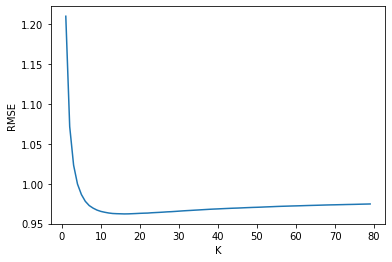

In [284]:
'''
Task 3 part f - plot performance of UCF versus K, and find the minimum
'''
y = list(map(lambda x: np.mean(x['test_rmse']), out_ucf_k))

fig, ax = plt.subplots()
ax.plot(ucf_k_range, y)
ax.set_ylabel('RMSE')
ax.set_xlabel('K')

plt.savefig('/home/jimge/public/CAP5610/hw5/UCF-K.png')

l = list(zip(ucf_k_range, y))
#print(l)
min(l, key=lambda x: x[1])

In [142]:
icf_k_range = list(range(1,80))
icf_k_out = []
for k in icf_k_range:
    t = time()
    ucf = cross_validate(KNNBasic(k=k, sim_options={'user_based': False}, verbose=False), data, ['rmse'], kf)
    print(time()-t)
    icf_k_out += [ucf]

37.51106595993042
37.91109871864319
39.558127641677856
39.82866096496582
39.36867046356201
40.22761940956116
40.44986867904663
39.51140761375427
40.488181352615356
40.43969511985779
39.67243194580078
39.90096187591553
40.95035934448242
40.16955327987671
40.23811459541321
41.24489212036133
40.742802143096924
40.681533336639404
41.48475003242493
41.03447914123535
41.37857961654663
42.026389360427856
41.6087601184845
42.61497449874878
42.045777320861816
42.710227727890015
42.839415311813354
42.065420150756836
43.14369869232178
42.37712788581848
42.86094546318054
43.72067952156067
42.85179018974304
43.872732400894165
43.438114404678345
43.89833664894104
43.78305673599243
44.73292875289917
43.91313886642456
44.05300164222717
45.54487705230713
44.32506203651428
46.77572417259216
46.49984955787659
46.208110094070435
47.57520508766174
45.73621392250061
46.95440101623535
48.620423793792725
47.07726573944092
46.56076717376709
49.258610010147095
48.37233090400696
48.122570514678955
48.76348924636

(15, 0.9621448358613593)

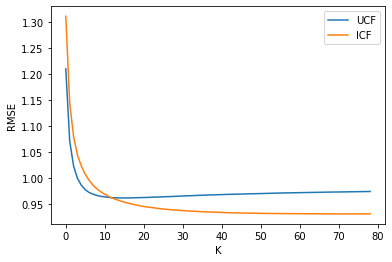

In [285]:
x = np.arange(80)

y0 = list(map(lambda x: np.mean(x['test_rmse']), out_ucf_k))
y1 = list(map(lambda x: np.mean(x['test_rmse']), icf_k_out))

fig, ax = plt.subplots()
ax.plot(np.arange(len(y0)), y0, label='UCF')
ax.plot(np.arange(len(y1)), y1, label='ICF')
ax.legend()
ax.set_ylabel('RMSE')
ax.set_xlabel('K')

plt.savefig('/home/jimge/public/CAP5610/hw5/UCF-ICF-K.png')

l = list(zip(x,y))
#print(l)
min(l, key=lambda x: x[1])